In [ ]:
import json
import random

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("../data/raw/gtsrb-german-traffic-sign/Train.csv")
test_df = pd.read_csv("../data/raw/gtsrb-german-traffic-sign/Test.csv")

In [3]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
# Filter the columns out
train_df = train_df[["Path", "ClassId"]]
test_df = test_df[["Path", "ClassId"]]

In [6]:
# Check for missing values
train_df.isna().sum()

Path       0
ClassId    0
dtype: int64

In [7]:
# Addthe full path to the images
train_df["Path"] = "gtsrb-german-traffic-sign/" + train_df["Path"]
test_df["Path"] = "gtsrb-german-traffic-sign/" + test_df["Path"]

In [ ]:
train_df.head(2)

,Path,ClassId
0,gtsrb-german-traffic-sign/Train/20/00020_00000...,20
1,gtsrb-german-traffic-sign/Train/20/00020_00000...,20


In [35]:
# Read the labels
with open ("../src/preprocess/labels.json", "r") as file:
    label_names = json.load(file)

In [46]:
label_names['labels']['0']

'Speed limit(20km/h)'

image shape : (47, 46, 3)
Image label: No passing for vehicles over 3.5 metric tons


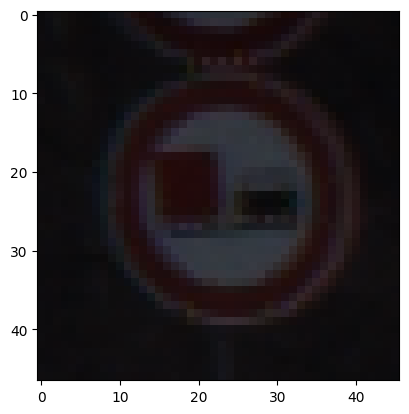

In [56]:
# Visualization
random_img_path = random.choice(train_df["Path"])
img_path = "../data/raw/" + random_img_path

img = plt.imread(img_path)
print(f'image shape : {img.shape}')
print(f'Image label: {label_names['labels'][str(train_df[train_df["Path"] == random_img_path]["ClassId"].values[0])]}')
plt.imshow(plt.imread(img_path))

In [57]:
# Check the min shape and the max shape
train_df["Path"].apply(lambda x: plt.imread("../data/raw/" + x).shape).min()

(25, 25, 3)

# Preprocessing the images

In [130]:
from sklearn.model_selection import train_test_split

import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [122]:
# Preprocess the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data
train_data = datasets.ImageFolder("../data/raw/gtsrb-german-traffic-sign/Train", transform=transform)
train, valid = train_test_split(train_data, test_size=0.2, random_state=42)

# Create the dataloaders
train_loader = DataLoader(train, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid, batch_size=32, shuffle=True)

In [178]:
class CustomTestDataset():
    def __init__(self, data, transform=None):
        # self.data = pd.read_csv(PATH)
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the img and its label
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        # Open the imgage to convert it to a tensor
        img_path = "../data/raw/" + img_path # this is only for the notebook
        image = Image.open(img_path).convert("RGB")

        # Apply the transform
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [167]:
test_df[test_df.Path == "gtsrb-german-traffic-sign/Test/03445.png"]

,Path,ClassId
3445,gtsrb-german-traffic-sign/Test/03445.png,1


In [179]:
test = CustomTestDataset(test_df, transform=transform)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [180]:
img, label = next(iter(test_loader))

In [201]:
X_train, y_train = next(iter(train_loader))
X_valid, y_valid = next(iter(valid_loader))
X_test, y_test = next(iter(test_loader))

In [202]:
# Check the shape (channels, height, width)
X_train[0].shape

torch.Size([3, 32, 32])

In [203]:
# we need shape (height, width, channels) to plot the image
X_train[0].permute(1,2,0).shape

torch.Size([32, 32, 3])

In [204]:
label_names['labels']['0']

'Speed limit(20km/h)'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.64].


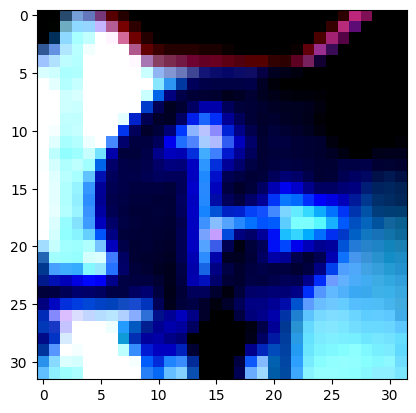

In [209]:
plt.imshow(X_train[1].permute(1,2,0))

In [210]:
# Convert the tensors to numpy arrays (for JAX)
X_train, y_train, X_valid, y_valid, X_test, y_test = X_train.numpy(), y_train.numpy(), X_valid.numpy(), y_valid.numpy(), X_test.numpy(), y_test.numpy()

# Training the model

In [108]:
# Using Jax to train the model
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp
import optax
from tqdm.auto import tqdm
import flax
from flax import linen as nn
from flax.training import train_state

jax.local_devices()

[CudaDevice(id=0)]